# Project 2

## Import required modules

In [49]:
from collections.abc import Sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Import provided code

In [2]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

## Data preparations

### Import data

In [3]:
training_set = pd.read_csv('https://raw.githubusercontent.com/dinhphucv/CSC-180/main/Projects/Project%202/data/UNSW_NB15_training-set.csv', chunksize=10000).read()
training_set.iloc[0:5]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
test_set = pd.read_csv('https://raw.githubusercontent.com/dinhphucv/CSC-180/main/Projects/Project%202/data/UNSW_NB15_test-set.csv', chunksize=10000).read()
test_set.iloc[0:5]

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [5]:
print('\'training_set\' original shape:', training_set.shape)
print('\'test_set\' original shape:', test_set.shape)

'training_set' original shape: (175341, 45)
'test_set' original shape: (82332, 45)


### Drop rows with missing values

In [6]:
training_set.dropna(inplace=True)
test_set.dropna(inplace=True)

### Remove unnecessary columns

In [7]:
training_set.drop(columns=['id'], axis=1, inplace=True)
test_set.drop(columns=['id'], axis=1, inplace=True)

### Remove duplicated rows

In [8]:
print('Duplicated rows in \'training_set\' dataset:', training_set.duplicated().sum())
if training_set.duplicated().sum() > 0:
  training_set.drop_duplicates(inplace=True)
print('Duplicated rows in \'test_set\' dataset:', test_set.duplicated().sum())
if test_set.duplicated().sum() > 0:
  test_set.drop_duplicates(inplace=True)

Duplicated rows in 'training_set' dataset: 67601
Duplicated rows in 'test_set' dataset: 26387


In [9]:
print('\'training_set\' current shape:', training_set.shape)
print('\'test_set\' current shape:', test_set.shape)

'training_set' current shape: (107740, 44)
'test_set' current shape: (55945, 44)


### Normalizing

In [10]:
columns_not_to_normalize = ['attack_cat', 'proto', 'service', 'state', 'is_ftp_login', 'is_sm_ips_ports', 'label']
columns_to_normalize = training_set.columns.difference(columns_not_to_normalize)
print(len(columns_to_normalize))
columns_to_normalize


37


Index(['ackdat', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'ct_src_ltm',
       'ct_srv_dst', 'ct_srv_src', 'ct_state_ttl', 'dbytes', 'dinpkt', 'djit',
       'dload', 'dloss', 'dmean', 'dpkts', 'dtcpb', 'dttl', 'dur', 'dwin',
       'rate', 'response_body_len', 'sbytes', 'sinpkt', 'sjit', 'sload',
       'sloss', 'smean', 'spkts', 'stcpb', 'sttl', 'swin', 'synack', 'tcprtt',
       'trans_depth'],
      dtype='object')

In [11]:
for column in columns_to_normalize:
  training_set[column] = zscore(training_set[column])
  test_set[column] = zscore(test_set[column])

In [12]:
training_set

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,-0.223580,tcp,-,FIN,-0.139493,-0.190846,-0.060940,-0.131903,-0.331102,1.010875,...,-0.210847,-0.491429,0,-0.130326,-0.314421,-0.582585,-0.610714,0,Normal,0
1,-0.127877,tcp,-,FIN,-0.093361,0.058156,-0.058802,0.102349,-0.331064,-0.752046,...,-0.210847,-0.328989,0,-0.130326,-0.314421,-0.582585,0.196045,0,Normal,0
2,0.048383,tcp,-,FIN,-0.127960,-0.102963,-0.060464,-0.059044,-0.331616,-0.752046,...,-0.210847,-0.166549,0,-0.130326,-0.314421,-0.382076,0.196045,0,Normal,0
3,0.058980,tcp,ftp,FIN,-0.104894,-0.132257,-0.059279,-0.128555,-0.331620,-0.752046,...,-0.210847,-0.166549,1,7.398544,-0.314421,-0.382076,-0.610714,0,Normal,0
4,-0.164180,tcp,-,FIN,-0.116427,-0.176199,-0.059701,-0.131365,-0.331451,1.029432,...,-0.210847,5.843741,0,-0.130326,-0.314421,-0.382076,5.520653,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175267,0.101118,tcp,smtp,FIN,0.252625,-0.000433,0.252305,-0.120930,-0.331276,-0.752046,...,-0.210847,-0.491429,0,-0.130326,-0.314421,2.826065,-0.610714,0,Exploits,1
175277,0.427983,tcp,-,FIN,0.206494,2.269876,-0.048238,2.254789,-0.330804,-0.752046,...,-0.210847,-0.491429,0,-0.130326,-0.314421,-0.382076,-0.610714,0,Exploits,1
175299,-0.065105,tcp,pop3,FIN,-0.058763,-0.000433,-0.057868,-0.039461,-0.331316,-0.752046,...,-0.210847,-0.491429,0,-0.130326,-0.314421,0.620468,-0.610714,0,Exploits,1
175305,0.036429,tcp,smtp,FIN,-0.012631,-0.059021,-0.005500,-0.121926,-0.331467,-0.752046,...,-0.210847,-0.328989,0,-0.130326,-0.314421,-0.382076,-0.610714,0,Exploits,1


In [13]:
test_set

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,-0.252515,udp,-,INT,-0.146002,-0.179927,-0.051333,-0.104541,0.422043,0.933831,...,-0.217036,-0.285107,0,-0.097247,-0.280678,-0.588983,-0.516027,0,Normal,0
1,-0.252515,udp,-,INT,-0.146002,-0.179927,-0.045112,-0.104541,0.712304,0.933831,...,-0.217036,-0.285107,0,-0.097247,-0.280678,-0.588983,-0.516027,0,Normal,0
2,-0.252516,udp,-,INT,-0.146002,-0.179927,-0.048522,-0.104541,1.350877,0.933831,...,-0.217036,-0.135725,0,-0.097247,-0.280678,-0.588983,-0.372357,0,Normal,0
3,-0.252516,udp,-,INT,-0.146002,-0.179927,-0.049347,-0.104541,1.067067,0.933831,...,-0.217036,-0.135725,0,-0.097247,-0.280678,-0.385295,-0.372357,0,Normal,0
4,-0.252515,udp,-,INT,-0.146002,-0.179927,-0.043323,-0.104541,0.499446,0.933831,...,-0.217036,-0.135725,0,-0.097247,-0.280678,-0.385295,-0.372357,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82319,-0.054004,tcp,-,FIN,-0.095471,-0.136835,-0.050881,-0.103078,-0.351828,0.933831,...,-0.217036,0.013658,0,-0.097247,-0.280678,-0.588983,-0.228687,0,Normal,0
82322,-0.252516,udp,-,INT,-0.146002,-0.179927,-0.053259,-0.104541,1.776593,0.933831,...,-0.217036,-0.434490,0,-0.097247,-0.280678,-0.588983,-0.659696,0,Normal,0
82323,1.010917,tcp,-,FIN,0.523536,-0.007558,0.624682,-0.098855,-0.351769,0.933831,...,-0.217036,-0.434490,0,-0.097247,-0.280678,-0.588983,-0.372357,0,Normal,0
82327,-0.252516,udp,-,INT,-0.146002,-0.179927,-0.053259,-0.104541,1.350877,0.933831,...,-0.217036,-0.285107,0,-0.097247,-0.280678,-0.385295,-0.659696,0,Normal,0


### Remove uncommon categorical values from both dataset

In [14]:
categorical_columns = ['proto', 'service', 'state', 'attack_cat']
for column in categorical_columns:
  training_unique = np.sort(training_set[column].unique())
  test_unique = np.sort(test_set[column].unique())
  if not np.array_equal(training_unique, test_unique):
    print('Values in', column, 'are not the same')

Values in proto are not the same
Values in state are not the same


In [15]:
common_proto_values = np.intersect1d(training_set['proto'], test_set['proto'])
common_proto_values

array(['3pc', 'a/n', 'aes-sp3-d', 'any', 'argus', 'aris', 'arp', 'ax.25',
       'bbn-rcc', 'bna', 'br-sat-mon', 'cbt', 'cftp', 'chaos',
       'compaq-peer', 'cphb', 'cpnx', 'crtp', 'crudp', 'dcn', 'ddp',
       'ddx', 'dgp', 'egp', 'eigrp', 'emcon', 'encap', 'etherip', 'fc',
       'fire', 'ggp', 'gmtp', 'gre', 'hmp', 'i-nlsp', 'iatp', 'ib',
       'idpr', 'idpr-cmtp', 'idrp', 'ifmp', 'igmp', 'igp', 'il', 'ip',
       'ipcomp', 'ipcv', 'ipip', 'iplt', 'ipnip', 'ippc', 'ipv6',
       'ipv6-frag', 'ipv6-no', 'ipv6-opts', 'ipv6-route', 'ipx-n-ip',
       'irtp', 'isis', 'iso-ip', 'iso-tp4', 'kryptolan', 'l2tp', 'larp',
       'leaf-1', 'leaf-2', 'merit-inp', 'mfe-nsp', 'mhrp', 'micp',
       'mobile', 'mtp', 'mux', 'narp', 'netblt', 'nsfnet-igp', 'nvp',
       'ospf', 'pgm', 'pim', 'pipe', 'pnni', 'pri-enc', 'prm', 'ptp',
       'pup', 'pvp', 'qnx', 'rdp', 'rsvp', 'rvd', 'sat-expak', 'sat-mon',
       'sccopmce', 'scps', 'sctp', 'sdrp', 'secure-vmtp', 'sep', 'skip',
       'sm', 'smp', 

In [16]:
common_state_values = np.intersect1d(training_set['state'], test_set['state'])
common_state_values

array(['CON', 'FIN', 'INT', 'REQ', 'RST'], dtype=object)

In [17]:
filtered_training = training_set[training_set['state'].isin(common_state_values)].copy()
filtered_training = filtered_training[filtered_training['proto'].isin(common_proto_values)].copy()
filtered_test = test_set[test_set['state'].isin(common_state_values)].copy()
filtered_test = filtered_test[filtered_test['proto'].isin(common_proto_values)].copy()
print('\'filtered_training\' current shape:', filtered_training.shape)
print('\'filtered_test\' current shape:', filtered_test.shape)

'filtered_training' current shape: (107726, 44)
'filtered_test' current shape: (55940, 44)


### One Hot Encoding

In [18]:
categorical_columns = ['proto', 'service', 'state']

In [19]:
df_training = pd.get_dummies(filtered_training, columns=categorical_columns)
df_test = pd.get_dummies(filtered_test, columns=categorical_columns)

In [20]:
df_training

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,-0.223580,-0.139493,-0.190846,-0.060940,-0.131903,-0.331102,1.010875,1.141228,-0.234937,-0.358601,...,0,0,0,0,0,0,1,0,0,0
1,-0.127877,-0.093361,0.058156,-0.058802,0.102349,-0.331064,-0.752046,1.123989,-0.234965,-0.194330,...,0,0,0,0,0,0,1,0,0,0
2,0.048383,-0.127960,-0.102963,-0.060464,-0.059044,-0.331616,-0.752046,1.123989,-0.234997,-0.341203,...,0,0,0,0,0,0,1,0,0,0
3,0.058980,-0.104894,-0.132257,-0.059279,-0.128555,-0.331620,-0.752046,1.123989,-0.234991,-0.360306,...,0,0,0,0,0,0,1,0,0,0
4,-0.164180,-0.116427,-0.176199,-0.059701,-0.131365,-0.331451,1.029432,1.123989,-0.234964,-0.360097,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175267,0.101118,0.252625,-0.000433,0.252305,-0.120930,-0.331276,-0.752046,1.123989,-0.233639,-0.358562,...,0,1,0,0,0,0,1,0,0,0
175277,0.427983,0.206494,2.269876,-0.048238,2.254789,-0.330804,-0.752046,1.123989,-0.234973,-0.057916,...,0,0,0,0,0,0,1,0,0,0
175299,-0.065105,-0.058763,-0.000433,-0.057868,-0.039461,-0.331316,-0.752046,1.123989,-0.234970,-0.318458,...,0,0,0,0,0,0,1,0,0,0
175305,0.036429,-0.012631,-0.059021,-0.005500,-0.121926,-0.331467,-0.752046,1.123989,-0.234709,-0.358239,...,0,1,0,0,0,0,1,0,0,0


In [21]:
df_test

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,-0.252515,-0.146002,-0.179927,-0.051333,-0.104541,0.422043,0.933831,-1.116899,0.678004,-0.323825,...,0,0,0,0,0,0,0,1,0,0
1,-0.252515,-0.146002,-0.179927,-0.045112,-0.104541,0.712304,0.933831,-1.116899,4.265167,-0.323825,...,0,0,0,0,0,0,0,1,0,0
2,-0.252516,-0.146002,-0.179927,-0.048522,-0.104541,1.350877,0.933831,-1.116899,4.128978,-0.323825,...,0,0,0,0,0,0,0,1,0,0
3,-0.252516,-0.146002,-0.179927,-0.049347,-0.104541,1.067067,0.933831,-1.116899,2.826485,-0.323825,...,0,0,0,0,0,0,0,1,0,0
4,-0.252515,-0.146002,-0.179927,-0.043323,-0.104541,0.499446,0.933831,-1.116899,4.108499,-0.323825,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82319,-0.054004,-0.095471,-0.136835,-0.050881,-0.103078,-0.351828,0.933831,1.020781,-0.245407,-0.323052,...,0,0,0,0,0,0,1,0,0,0
82322,-0.252516,-0.146002,-0.179927,-0.053259,-0.104541,1.776593,0.933831,-1.116899,0.287032,-0.323825,...,0,0,0,0,0,0,0,1,0,0
82323,1.010917,0.523536,-0.007558,0.624682,-0.098855,-0.351769,0.933831,1.020781,-0.244349,-0.323283,...,0,0,0,0,0,0,1,0,0,0
82327,-0.252516,-0.146002,-0.179927,-0.053259,-0.104541,1.350877,0.933831,-1.116899,0.180539,-0.323825,...,0,0,0,0,0,0,0,1,0,0


### Separate

In [22]:
#columns_to_drop = ['label', 'attack_cat_Analysis', 'attack_cat_Backdoor', 'attack_cat_DoS', 'attack_cat_Exploits', 'attack_cat_Fuzzers', 'attack_cat_Generic', 'attack_cat_Normal', 'attack_cat_Reconnaissance', 'attack_cat_Shellcode', 'attack_cat_Worms']
columns_to_drop = ['attack_cat', 'label']
x_train = df_training.drop(columns=columns_to_drop, axis=1)
y_train = df_training['label']
x_test = df_test.drop(columns=columns_to_drop, axis=1)
y_test = df_test['label']

## Logistic Regression

In [23]:
logreg = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr')

In [24]:
pred = logreg.predict(x_test)

### Result

[[27836  6368]
 [ 4260 17476]]


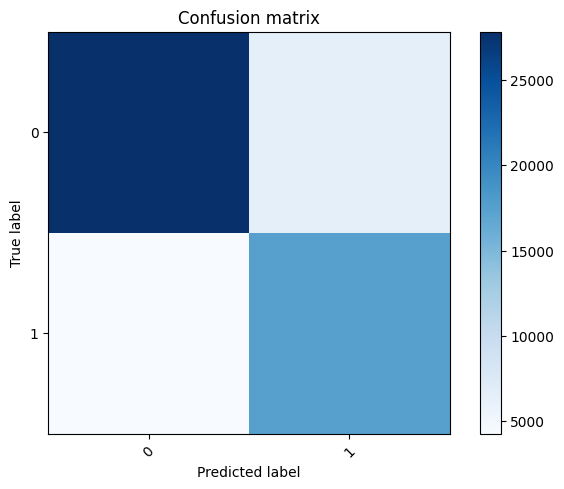

In [25]:
cm = confusion_matrix(y_test, pred)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

In [26]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     34204
           1       0.73      0.80      0.77     21736

    accuracy                           0.81     55940
   macro avg       0.80      0.81      0.80     55940
weighted avg       0.82      0.81      0.81     55940



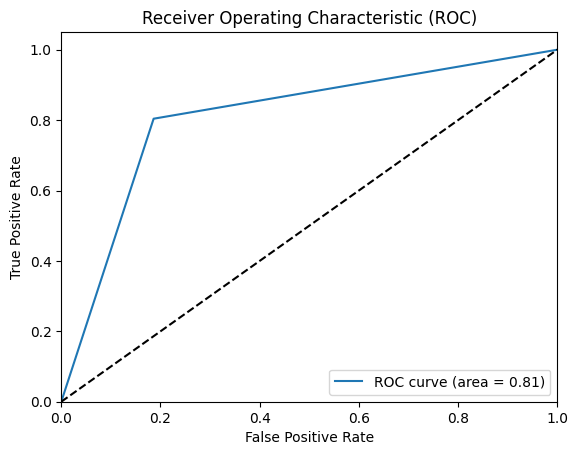

In [27]:
plot_roc(pred, y_test)

## Support Vector Machine

In [28]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)

SVC()

In [29]:
pred = svm_model.predict(x_test)

### Result

[[20395 13809]
 [  157 21579]]


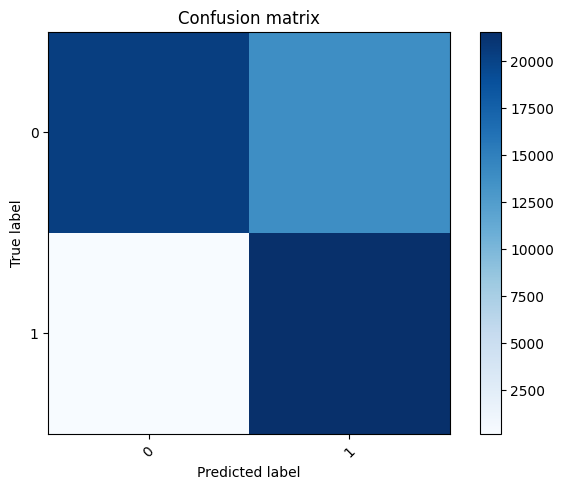

In [31]:
cm = confusion_matrix(y_test, pred)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

In [32]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.60      0.74     34204
           1       0.61      0.99      0.76     21736

    accuracy                           0.75     55940
   macro avg       0.80      0.79      0.75     55940
weighted avg       0.84      0.75      0.75     55940



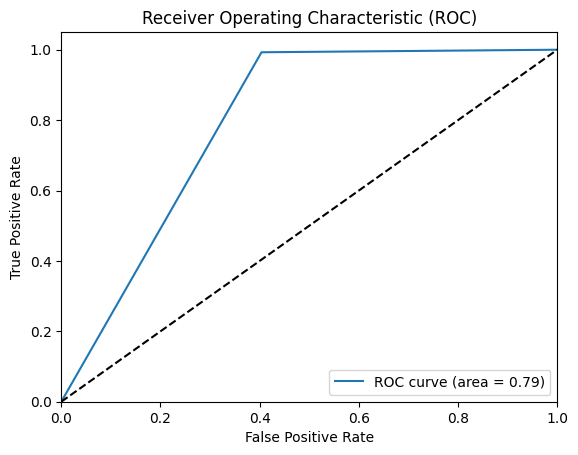

In [33]:
plot_roc(pred, y_test)

## Fully-Connected Neural Networks

### Model 1

In [86]:
checkpointer = ModelCheckpoint(filepath="dnn/d_r_a_25101_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Dense(25, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_r_a_25101_best_weights.hdf5') # load weights from best model
model.summary()

0
Epoch 1/1000
3367/3367 - 16s - loss: 0.2108 - accuracy: 0.9014 - val_loss: 0.5072 - val_accuracy: 0.7474 - 16s/epoch - 5ms/step
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3367/3367 - 16s - loss: 0.1786 - accuracy: 0.9119 - val_loss: 0.4601 - val_accuracy: 0.7663 - 16s/epoch - 5ms/step
Epoch 3/1000
3367/3367 - 15s - loss: 0.1742 - accuracy: 0.9143 - val_loss: 0.4561 - val_accuracy: 0.7659 - 15s/epoch - 4ms/step
Epoch 4/1000
3367/3367 - 15s - loss: 0.1717 - accuracy: 0.9153 - val_loss: 0.4569 - val_accuracy: 0.7700 - 15s/epoch - 4ms/step
Epoch 5/1000
3367/3367 - 16s - loss: 0.1699 - accuracy: 0.9157 - val_loss: 0.4443 - val_accuracy: 0.7684 - 16s/epoch - 5ms/step
Epoch 6/1000
3367/3367 - 13s - loss: 0.1684 - accuracy: 0.9164 - val_loss: 0.4783 - val_accuracy: 0.7648 - 13s/epoch - 4ms/step
Epoch 7/1000
3367/3367 - 15s - loss: 0.1676 - accuracy: 0.9169 - val_loss: 0.4321 - val_accuracy: 0.7639 - 15s/epoch - 4ms/step
Epoch 8/1000
3367/3367 - 20s - loss: 0.1667 - accuracy: 0.9174 - val_loss: 0.4558 - val_accuracy: 0.7559 - 20s/epoch - 6ms/step
Epoch 9/1000
3367/3367 - 18s - loss: 0.1659 - accuracy: 0.9179 - val_loss: 0.4559 - val_accuracy: 0.7614 - 18s/epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3367/3367 - 14s - loss: 0.1753 - accuracy: 0.9123 - val_loss: 0.3950 - val_accuracy: 0.7771 - 14s/epoch - 4ms/step
Epoch 4/1000
3367/3367 - 15s - loss: 0.1736 - accuracy: 0.9138 - val_loss: 0.3984 - val_accuracy: 0.7816 - 15s/epoch - 4ms/step
Epoch 5/1000
3367/3367 - 16s - loss: 0.1715 - accuracy: 0.9149 - val_loss: 0.4573 - val_accuracy: 0.7642 - 16s/epoch - 5ms/step
Epoch 6/1000
3367/3367 - 16s - loss: 0.1705 - accuracy: 0.9141 - val_loss: 0.4677 - val_accuracy: 0.7563 - 16s/epoch - 5ms/step
Epoch 7/1000
3367/3367 - 14s - loss: 0.1690 - accuracy: 0.9156 - val_loss: 0.4495 - val_accuracy: 0.7649 - 14s/epoch - 4ms/step
Epoch 7: early stopping
2
Epoch 1/1000
3367/3367 - 17s - loss: 0.2067 - accuracy: 0.9029 - val_loss: 0.5032 - val_accuracy: 0.7576 - 17s/epoch - 5ms/step
Epoch 2/1000
3367/3367 - 15s - loss: 0.1788 - accuracy: 0.9115 - val_loss: 0.4427 - val_accuracy: 0.7699 - 15s/epoch - 4ms/step
Epoch 3/1000
3367/3367 - 13s - loss: 0.1743 - accuracy: 0.9131 - val_loss: 0.4985 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3367/3367 - 15s - loss: 0.1669 - accuracy: 0.9169 - val_loss: 0.4755 - val_accuracy: 0.7616 - 15s/epoch - 4ms/step
Epoch 8/1000
3367/3367 - 13s - loss: 0.1658 - accuracy: 0.9166 - val_loss: 0.4458 - val_accuracy: 0.7764 - 13s/epoch - 4ms/step
Epoch 9/1000
3367/3367 - 13s - loss: 0.1649 - accuracy: 0.9176 - val_loss: 0.4334 - val_accuracy: 0.7804 - 13s/epoch - 4ms/step
Epoch 10/1000
3367/3367 - 14s - loss: 0.1641 - accuracy: 0.9179 - val_loss: 0.4518 - val_accuracy: 0.7734 - 14s/epoch - 4ms/step
Epoch 11/1000
3367/3367 - 15s - loss: 0.1631 - accuracy: 0.9181 - val_loss: 0.4339 - val_accuracy: 0.7712 - 15s/epoch - 4ms/step
Epoch 11: early stopping
Training finished...Loading the best model

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 25)                4725      
                                                                 
 dense_55 (Dens

In [ ]:
pred = cnn.predict(x_test_array)
pred_rounded = np.round(pred)).astype(int)

### Model 2

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_s_a_25101_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(25, input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_s_a_25101_best_weights.hdf5') # load weights from best model
model.summary()

### Model 3

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_t_a_25101_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(25, input_dim=x_train.shape[1], activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_t_a_25101_best_weights.hdf5') # load weights from best model
model.summary()

### Model 4

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_r_a_50251_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test]), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_r_a_50251_best_weights.hdf5') # load weights from best model
model.summary()

### Model 5

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_s_a_50251_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(50, input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(Dense(25, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_s_a_50251_best_weights.hdf5') # load weights from best model
model.summary()

### Model 6

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_t_a_50251_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(50, input_dim=x_train.shape[1], activation='tanh'))
    model.add(Dense(25, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_t_a_50251_best_weights.hdf5') # load weights from best model
model.summary()

### Model 7

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_r_a_5025101_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(50, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_r_a_5025101_best_weights.hdf5') # load weights from best model
model.summary()

### Model 8

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_s_a_5025101_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(50, input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(Dense(25, activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_s_a_5025101_best_weights.hdf5') # load weights from best model
model.summary()

### Model 9

In [ ]:
checkpointer = ModelCheckpoint(filepath="dnn/d_t_a_5025101_best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(3):
    print(i)
    model = Sequential()
    model.add(Dense(50, input_dim=x_train.shape[1], activation='tanh'))
    model.add(Dense(25, activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
model.load_weights('dnn/d_t_a_5025101_best_weights.hdf5') # load weights from best model
model.summary()

## Convolutional Neural Networks

### Reshape

In [34]:
x_train_array = np.array(x_train)
x_train_array = x_train_array.reshape(x_train_array.shape[0], 1, x_train_array.shape[1], 1)
x_test_array = np.array(x_test)
x_test_array = x_test_array.reshape(x_test_array.shape[0], 1, x_test_array.shape[1], 1)

In [35]:
x_train_array.shape

(107726, 1, 188, 1)

In [70]:
sample_input_shape = (1, 188, 1)

### Model 1

In [71]:
checkpointer = ModelCheckpoint(filepath="cnn/best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(5):
  print(i)

  cnn = Sequential()
  cnn.add(Conv2D(64,
                kernel_size=(1, 3),
                strides=(1, 1),
                activation='relu',
                input_shape=sample_input_shape))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(128,
                kernel_size=(1, 3),
                strides=(1, 1),
                activation='relu'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Flatten())
  cnn.add(Dense(1024, activation="relu"))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(1, activation="sigmoid"))
  cnn.compile(loss="binary_crossentropy", optimizer="adam")
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
  cnn.fit(x_train_array, y_train, validation_data=(x_test_array, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
cnn.load_weights('cnn/best_weights.hdf5') # load weights from best model
cnn.summary()

Epoch 1/1000
3367/3367 - 68s - loss: 0.1966 - val_loss: 0.4609 - 68s/epoch - 20ms/step
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3367/3367 - 16s - loss: 0.1765 - val_loss: 0.3999 - 16s/epoch - 5ms/step
Epoch 3/1000
3367/3367 - 18s - loss: 0.1708 - val_loss: 0.3623 - 18s/epoch - 5ms/step
Epoch 4/1000
3367/3367 - 16s - loss: 0.1674 - val_loss: 0.3893 - 16s/epoch - 5ms/step
Epoch 5/1000
3367/3367 - 15s - loss: 0.1652 - val_loss: 0.4680 - 15s/epoch - 5ms/step
Epoch 6/1000
3367/3367 - 16s - loss: 0.1633 - val_loss: 0.4335 - 16s/epoch - 5ms/step
Epoch 7/1000
3367/3367 - 17s - loss: 0.1619 - val_loss: 0.4782 - 17s/epoch - 5ms/step
Epoch 8/1000
3367/3367 - 17s - loss: 0.1601 - val_loss: 0.4038 - 17s/epoch - 5ms/step
Epoch 8: early stopping
Epoch 1/1000
3367/3367 - 17s - loss: 0.1966 - val_loss: 0.4083 - 17s/epoch - 5ms/step
Epoch 2/1000
3367/3367 - 16s - loss: 0.1762 - val_loss: 0.3897 - 16s/epoch - 5ms/step
Epoch 3/1000
3367/3367 - 16s - loss: 0.1715 - val_loss: 0.4471 - 16s/epoch - 5ms/step
Epoch 4/1000
3367/3367 - 16s - loss: 0.1687 - val_loss: 0.3854 - 16s/epoch - 5ms/step
Epoch 5/1000
3367/3367 - 17s - loss: 0.1653

In [72]:
pred = np.round(cnn.predict(x_test_array)).astype(int)

1749/1749 [==============================] - 3s 2ms/step


[[23268 10936]
 [  309 21427]]


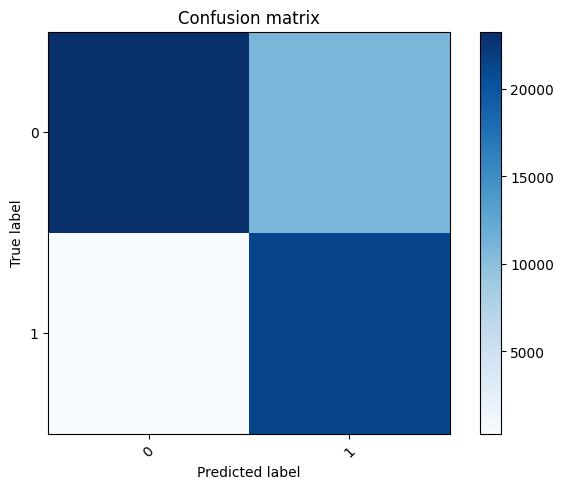

In [73]:
cm = confusion_matrix(y_test, pred)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

In [74]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81     34204
           1       0.66      0.99      0.79     21736

    accuracy                           0.80     55940
   macro avg       0.82      0.83      0.80     55940
weighted avg       0.86      0.80      0.80     55940



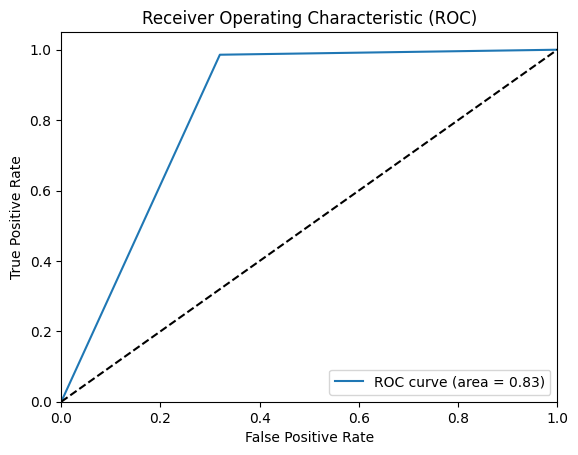

In [75]:
plot_roc(pred, y_test)

### Model 2

In [76]:
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_2.hdf5", verbose=0, save_best_only=True)

for i in range(5):
  print(i)

  cnn = Sequential()
  cnn.add(Conv2D(64,
                kernel_size=(1, 3),
                strides=(1, 1),
                activation='sigmoid',
                input_shape=sample_input_shape))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(128,
                kernel_size=(1, 3),
                strides=(1, 1),
                activation='sigmoid'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Flatten())
  cnn.add(Dense(1024, activation="sigmoid"))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(1, activation="sigmoid"))
  cnn.compile(loss="binary_crossentropy", optimizer="adam")
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
  cnn.fit(x_train_array, y_train, validation_data=(x_test_array, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
cnn.load_weights('cnn/best_weights_2.hdf5') # load weights from best model
cnn.summary()

Epoch 1/1000
3367/3367 - 19s - loss: 0.4981 - val_loss: 0.5705 - 19s/epoch - 6ms/step
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3367/3367 - 17s - loss: 0.2092 - val_loss: 0.5078 - 17s/epoch - 5ms/step
Epoch 3/1000
3367/3367 - 16s - loss: 0.1900 - val_loss: 0.3768 - 16s/epoch - 5ms/step
Epoch 4/1000
3367/3367 - 17s - loss: 0.1844 - val_loss: 0.5090 - 17s/epoch - 5ms/step
Epoch 5/1000
3367/3367 - 15s - loss: 0.1814 - val_loss: 0.5474 - 15s/epoch - 5ms/step
Epoch 6/1000
3367/3367 - 15s - loss: 0.1788 - val_loss: 0.4431 - 15s/epoch - 5ms/step
Epoch 7/1000
3367/3367 - 16s - loss: 0.1765 - val_loss: 0.4199 - 16s/epoch - 5ms/step
Epoch 8/1000
3367/3367 - 15s - loss: 0.1753 - val_loss: 0.4978 - 15s/epoch - 5ms/step
Epoch 8: early stopping
Epoch 1/1000
3367/3367 - 17s - loss: 0.6327 - val_loss: 0.6858 - 17s/epoch - 5ms/step
Epoch 2/1000
3367/3367 - 17s - loss: 0.2138 - val_loss: 0.5328 - 17s/epoch - 5ms/step
Epoch 3/1000
3367/3367 - 15s - loss: 0.1918 - val_loss: 0.5010 - 15s/epoch - 5ms/step
Epoch 4/1000
3367/3367 - 17s - loss: 0.1851 - val_loss: 0.4965 - 17s/epoch - 5ms/step
Epoch 5/1000
3367/3367 - 17s - loss: 0.1809

In [77]:
pred = np.round(cnn.predict(x_test_array)).astype(int)

1749/1749 [==============================] - 3s 2ms/step


[[23192 11012]
 [  583 21153]]


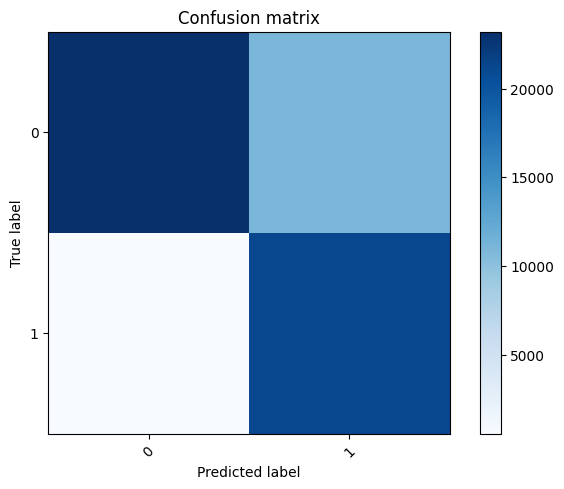

In [78]:
cm = confusion_matrix(y_test, pred)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

In [79]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.68      0.80     34204
           1       0.66      0.97      0.78     21736

    accuracy                           0.79     55940
   macro avg       0.82      0.83      0.79     55940
weighted avg       0.85      0.79      0.79     55940



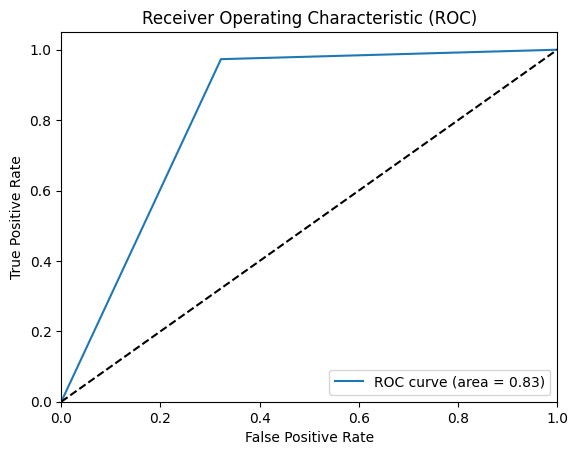

In [80]:
plot_roc(pred, y_test)

### Model 3

In [81]:
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_3.hdf5", verbose=0, save_best_only=True)

for i in range(5):
  print(i)

  cnn = Sequential()
  cnn.add(Conv2D(64,
                kernel_size=(1, 3),
                strides=(1, 1),
                activation='tanh',
                input_shape=sample_input_shape))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Conv2D(128,
                kernel_size=(1, 3),
                strides=(1, 1),
                activation='tanh'))
  cnn.add(MaxPooling2D(pool_size=(1,2)))
  cnn.add(Flatten())
  cnn.add(Dense(1024, activation="tanh"))
  cnn.add(Dropout(0.5))
  cnn.add(Dense(1, activation="sigmoid"))
  cnn.compile(loss="binary_crossentropy", optimizer="adam")
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
  cnn.fit(x_train_array, y_train, validation_data=(x_test_array, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=1000)

print('Training finished...Loading the best model')
print()
cnn.load_weights('cnn/best_weights_3.hdf5') # load weights from best model
cnn.summary()

Epoch 1/1000
3367/3367 - 18s - loss: 0.2101 - val_loss: 0.4366 - 18s/epoch - 5ms/step
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3367/3367 - 17s - loss: 0.1957 - val_loss: 0.6173 - 17s/epoch - 5ms/step
Epoch 3/1000
3367/3367 - 18s - loss: 0.1941 - val_loss: 0.4156 - 18s/epoch - 5ms/step
Epoch 4/1000
3367/3367 - 17s - loss: 0.1933 - val_loss: 0.5535 - 17s/epoch - 5ms/step
Epoch 5/1000
3367/3367 - 17s - loss: 0.1944 - val_loss: 0.3954 - 17s/epoch - 5ms/step
Epoch 6/1000
3367/3367 - 16s - loss: 0.1947 - val_loss: 0.4132 - 16s/epoch - 5ms/step
Epoch 7/1000
3367/3367 - 18s - loss: 0.1952 - val_loss: 0.3761 - 18s/epoch - 5ms/step
Epoch 8/1000
3367/3367 - 16s - loss: 0.1950 - val_loss: 0.4507 - 16s/epoch - 5ms/step
Epoch 9/1000
3367/3367 - 15s - loss: 0.1950 - val_loss: 0.3950 - 15s/epoch - 5ms/step
Epoch 10/1000
3367/3367 - 16s - loss: 0.1957 - val_loss: 0.5420 - 16s/epoch - 5ms/step
Epoch 11/1000
3367/3367 - 17s - loss: 0.1952 - val_loss: 0.4605 - 17s/epoch - 5ms/step
Epoch 12/1000
3367/3367 - 17s - loss: 0.1946 - val_loss: 0.4670 - 17s/epoch - 5ms/step
Epoch 12: early stopping
Epoch 1/1000
3367/3367 - 18s - loss: 0.

In [82]:
pred = np.round(cnn.predict(x_test_array)).astype(int)

1749/1749 [==============================] - 3s 2ms/step


[[27752  6452]
 [ 1600 20136]]


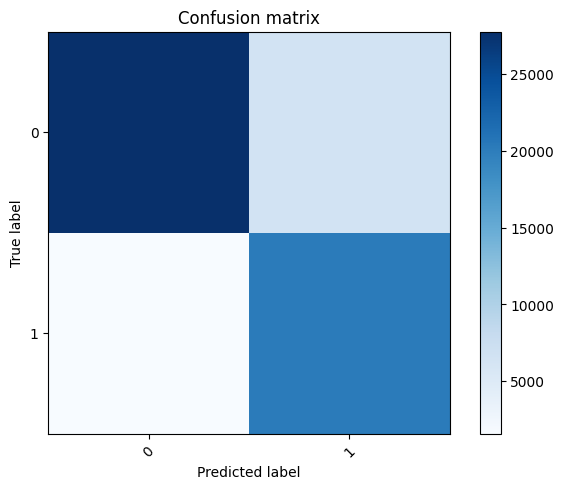

In [83]:
cm = confusion_matrix(y_test, pred)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['0', '1'])
plt.show()

In [84]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     34204
           1       0.76      0.93      0.83     21736

    accuracy                           0.86     55940
   macro avg       0.85      0.87      0.85     55940
weighted avg       0.87      0.86      0.86     55940



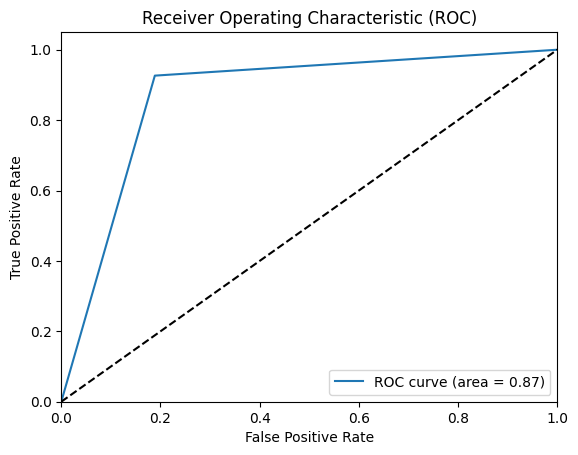

In [85]:
plot_roc(pred, y_test)